In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
## from pass_k
def estimator(n: int, c: int, k: int) -> float:
    """
    Calculates 1 - comb(n - c, k) / comb(n, k).
    """
    if n - c < k:
        return 1.0
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

def evaluate_data_3(df: pd.DataFrame, k: int, print_data=True):
    # State is unhashable, so we convert it to a string
    df["state_str"] = df["state"].apply(lambda x: str(x))
    df = df[["name", "state_str", "constraint", "completion", "is_sat"]]
    
    df = df.groupby(["name", "state_str"])
    df = df.agg(c=("is_sat", pd.Series.sum),
                n=("is_sat", pd.Series.count))
    
    df["pass1"]  = df.apply(lambda row: estimator(row["n"], row["c"], 1), axis=1)
    df = df.drop(columns=["c"])

    if print_data:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(df)
    return df

def calculate_results_table(eval_df: pd.DataFrame, print_table=True):
    def normalize(row):
        row["name"] = row["name"].split("-")[0]
        return row
    
    df = eval_df.reset_index(level=[0,1])

    state_means = df.groupby(["name"])["pass1"].mean().rename("state_mean").to_frame()
    state_means.reset_index(level=[0], inplace=True)
    
    norm_state_means = state_means.apply(lambda row: normalize(row), axis=1)
    
    prompt_means = norm_state_means.groupby(["name"])["state_mean"].mean().rename("mean")
    maxes = norm_state_means.groupby(["name"])["state_mean"].max().rename("max")
    mins = norm_state_means.groupby(["name"])["state_mean"].min().rename("min")

    results = pd.concat([maxes, mins, prompt_means], axis=1)
    
    results["+-"] = results.apply(lambda row: max(row["max"] - row["mean"],
                                                     row["mean"] - row["min"]), axis=1)
    results = results.apply(lambda row: round(row, 3))
    results = results.reset_index(level=[0])
    if print_table:
        print(results)
    return results

In [42]:
palm_df = pd.read_json(open("palm_eval.jsonl","r"), lines=True)
palm_df3 = evaluate_data_3(palm_df, 1, print_data=False)
palm_res = calculate_results_table(palm_df3, print_table=False)

gpt_df = pd.read_json(open("gpt_eval.jsonl","r"), lines=True)
gpt_df3 = evaluate_data_3(gpt_df, 1, print_data=False)
gpt_res = calculate_results_table(gpt_df3, print_table=False)

star_df = pd.read_json(open("starcoder_eval.jsonl","r"), lines=True)
star_df3 = evaluate_data_3(star_df, 1, print_data=False)
star_res = calculate_results_table(star_df3, print_table=False)

[[0.016 0.15  0.148 0.33  0.7  ]
 [0.034 0.2   0.09  0.37  0.25 ]]
             name    max  min   mean     +-
0    ElevatorTour  1.000  1.0  1.000  0.000
1   HalloweenList  1.000  0.9  0.980  0.080
2      LunchBreak  0.238  0.0  0.095  0.142
3  MovieMessenger  1.000  1.0  1.000  0.000
4   StaplerSupply  0.950  0.0  0.510  0.510


([<matplotlib.axis.XTick at 0x7f15cf40bac0>,
 [Text(0.25, 0, 'ElevatorTour'),
  Text(1.25, 0, 'HalloweenList'),
  Text(2.25, 0, 'LunchBreak'),
  Text(3.25, 0, 'MovieMessenger'),
  Text(4.25, 0, 'StaplerSupply')])

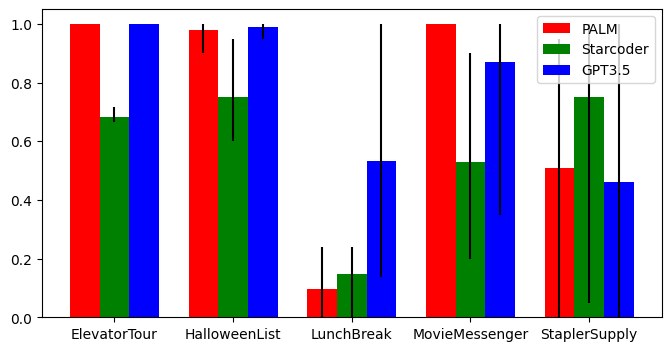

In [48]:
tasks_len = 5
palm = np.array(palm_res["mean"].tolist())
palm_min = np.array(palm_res["min"].tolist())
palm_max = np.array(palm_res["max"].tolist())

starcoder = np.array(star_res["mean"].tolist())
starcoder_min = np.array(star_res["min"].tolist())
starcoder_max = np.array(star_res["max"].tolist())

gpt = np.array(gpt_res["mean"].tolist())
gpt_min = np.array(gpt_res["min"].tolist())
gpt_max = np.array(gpt_res["max"].tolist())

barWidth = 0.25
br1 = np.arange(tasks_len)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


palm_err = abs(np.array([palm_min, palm_max]) - palm)
starcoder_err = abs(np.array([starcoder_min, starcoder_max]) - starcoder)
gpt_err = abs(np.array([gpt_min, gpt_max]) - gpt)

print(starcoder_err)
plt.figure(figsize=[8,4])
plt.bar(br1,palm, color ='r', width = barWidth, yerr=palm_err)
plt.bar(br2,starcoder, color ='g',width = barWidth, yerr=starcoder_err)
plt.bar(br3,gpt, color ='b',width = barWidth, yerr=gpt_err)

print(palm_res)
assert palm_res["name"].tolist() == star_res["name"].tolist() == gpt_res["name"].tolist()
assert len(palm_res["name"].tolist()) == tasks_len

plt.legend(["PALM", "Starcoder", "GPT3.5"])
plt.xticks([r + barWidth for r in range(tasks_len)],
        palm_res["name"].tolist())